# NVAE Debug Experiment with WandB & Overfitting Check

This debug notebook tests:
1. **WandB Logging**: Ensures metrics and images are logged correctly.
2. **Overfitting**: Uses the training set as the validation set to verify the model can learn.
3. **Config**: 10 Epochs, Subset of data.

## 1. Google Colab Setup
Mount Drive and clone the repository (Fresh Copy).

In [23]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os
import sys
import shutil

# --- CONFIGURATION ---
REPO_PATH = '/content/drive/MyDrive/Generative-Modeling-on-CIFAR-10'
REPO_URL = "https://github.com/konstantine25b/Generative-Modeling-on-CIFAR-10.git"

# 1. Delete repo if it already exists (Ensure fresh code)
if os.path.exists(REPO_PATH):
    print(f"Deleting existing repository at {REPO_PATH}...")
    shutil.rmtree(REPO_PATH)

# 2. Clone repository
os.chdir('/content/drive/MyDrive')
print(f"Cloning repository to {REPO_PATH}...")
!git clone {REPO_URL}

# 3. Enter the repository
os.chdir(REPO_PATH)
print(f"Current working directory: {os.getcwd()}")

# 4. Add source code to Python path
sys.path.append(os.path.join(REPO_PATH, 'src'))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Deleting existing repository at /content/drive/MyDrive/Generative-Modeling-on-CIFAR-10...
Cloning repository to /content/drive/MyDrive/Generative-Modeling-on-CIFAR-10...
Cloning into 'Generative-Modeling-on-CIFAR-10'...
remote: Enumerating objects: 130, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 130 (delta 53), reused 68 (delta 27), pack-reused 33 (from 1)
Receiving objects: 100% (130/130), 212.52 MiB | 18.67 MiB/s, done.
Resolving deltas: 100% (60/60), done.
Updating files: 100% (31/31), done.
Current working directory: /content/drive/MyDrive/Generative-Modeling-on-CIFAR-10


## 2. GitHub & WandB Configuration
**Important:** You need your WandB API key here.

In [24]:
# GitHub Configuration & Setup
import os

try:
    # 1. Configure Git
    user_name = "konstantine25b"
    mail = "konstantine25b@gmail.com"

    # --- IMPORTANT: PASTE YOUR TOKEN BELOW ---
    my_token = "YOUR_TOKEN_HERE"

    if my_token == "YOUR_TOKEN_HERE":
        print("⚠️ PLEASE UPDATE 'my_token' in the code cell with your actual GitHub token to enable pushing.")

    repo_url = f"https://{my_token}@github.com/konstantine25b/Generative-Modeling-on-CIFAR-10.git"

    !git config --global user.name "{user_name}"
    !git config --global user.email "{mail}"

    # 2. Set Remote URL
    if os.path.isdir(".git") and my_token != "YOUR_TOKEN_HERE":
        !git remote set-url origin "{repo_url}"
        print("Git configured successfully for pushing.")
    else:
        print("Skipping remote setup (either not a git repo or token not set).")

except Exception as e:
    print(f"Error setting up GitHub: {e}")

⚠️ PLEASE UPDATE 'my_token' in the code cell with your actual GitHub token to enable pushing.
Skipping remote setup (either not a git repo or token not set).


## 3. Install Dependencies

In [25]:
!pip install -r requirements.txt
!pip install wandb -q

# Login to WandB
import wandb
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


False

## 4. Setup WandB Test Experiment

In [27]:
import torch
from src.utils.data_loader import get_cifar10_loaders
from src.vae.train import train_vae
from src.vae.sampling import generate_samples, save_sample_grid
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# WandB Test Configuration
config = {
    'epochs': 10,         # Increased to 10
    'batch_size': 64,
    'lr': 1e-3,
    'hidden_dim': 64,
    'latent_dim': 20,
    'num_scales': 2,
    'warmup_epochs': 3,
    'weight_decay': 3e-4,
    'use_wandb': True,    # ENABLED WandB
    'run_name': 'nvae_debug_wandb_test',
    'model_save_dir': 'models/debug_wandb',
    'results_dir': 'results/debug_wandb'
}

# Create directories
os.makedirs(config['model_save_dir'], exist_ok=True)
os.makedirs(config['results_dir'], exist_ok=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


## 5. Load Data (Train set used as Val set)
We use a subset of the training data for both training AND validation to check for overfitting.

In [28]:
from torch.utils.data import DataLoader, Subset

full_train_loader, _, _ = get_cifar10_loaders(
    data_dir='./data',
    batch_size=config['batch_size']
)

# Create a small subset of training data (e.g., 2000 images)
def create_subset_loader(original_loader, size=2000):
    dataset = original_loader.dataset
    indices = list(range(size))
    subset = Subset(dataset, indices)

    return DataLoader(
        subset,
        batch_size=original_loader.batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )

# Create ONE subset loader
subset_loader = create_subset_loader(full_train_loader, size=5000)

# Use the SAME loader for both Train and Test to check overfitting capability
train_loader = subset_loader
val_loader = subset_loader

print(f"Using same subset ({len(train_loader.dataset)} images) for Train and Val.")

Data Loaders ready: Train=45000, Val=5000, Test=10000
Using same subset (5000 images) for Train and Val.


## 6. Train Model (WandB Enabled)

In [30]:
import src.vae.train
importlib.reload(src.vae.train)
from src.vae.train import train_vae

In [31]:
# Start Training
train_vae(config, train_loader, val_loader, device)

train/beta,▁
train/lr,▁
train/step_bpd,▁
train/step_kl,▁
train/step_loss,▁
train/step_recon,▁
train/beta,0.33333
train/lr,0.001
train/step_bpd,9.02577
train/step_kl,446.45795
train/step_loss,19219.00586


Model initialized on cuda


Epoch 1/10: 100%|██████████| 79/79 [00:11<00:00,  7.13it/s, loss=13572.25, bpd=6.37, beta=0.33]


=== Epoch 1 Summary ===
Train Loss: 14457.7418 | Recon: 14310.3047 | KL: 442.3115 | BPD: 6.7898


Val Loss:   15808.6517 | Val BPD: 7.4242
✅ Saved best model to models/debug_wandb/nvae_best.pth (Val Loss: 15808.6517)
💾 Saved epoch checkpoint to models/debug_wandb/nvae_epoch_1.pth


Epoch 2/10: 100%|██████████| 79/79 [00:11<00:00,  7.14it/s, loss=14097.94, bpd=6.62, beta=0.67]


=== Epoch 2 Summary ===
Train Loss: 13480.3077 | Recon: 13215.7402 | KL: 396.8513 | BPD: 6.3307


Val Loss:   14095.9307 | Val BPD: 6.6198
✅ Saved best model to models/debug_wandb/nvae_best.pth (Val Loss: 14095.9307)
💾 Saved epoch checkpoint to models/debug_wandb/nvae_epoch_2.pth


Epoch 3/10: 100%|██████████| 79/79 [00:10<00:00,  7.19it/s, loss=13241.05, bpd=6.22, beta=1.00]


=== Epoch 3 Summary ===
Train Loss: 13018.4597 | Recon: 12633.9162 | KL: 384.5436 | BPD: 6.1138


Val Loss:   12719.5082 | Val BPD: 5.9734
✅ Saved best model to models/debug_wandb/nvae_best.pth (Val Loss: 12719.5082)
💾 Saved epoch checkpoint to models/debug_wandb/nvae_epoch_3.pth


Epoch 4/10: 100%|██████████| 79/79 [00:10<00:00,  7.24it/s, loss=13077.41, bpd=6.14, beta=1.00]


=== Epoch 4 Summary ===
Train Loss: 12754.6956 | Recon: 12387.0355 | KL: 367.6601 | BPD: 5.9900


Val Loss:   12630.8854 | Val BPD: 5.9318
✅ Saved best model to models/debug_wandb/nvae_best.pth (Val Loss: 12630.8854)
💾 Saved epoch checkpoint to models/debug_wandb/nvae_epoch_4.pth


Epoch 5/10: 100%|██████████| 79/79 [00:10<00:00,  7.36it/s, loss=13571.17, bpd=6.37, beta=1.00]


=== Epoch 5 Summary ===
Train Loss: 12636.0474 | Recon: 12287.7391 | KL: 348.3083 | BPD: 5.9342


Val Loss:   12545.3653 | Val BPD: 5.8916
✅ Saved best model to models/debug_wandb/nvae_best.pth (Val Loss: 12545.3653)
💾 Saved epoch checkpoint to models/debug_wandb/nvae_epoch_5.pth


Epoch 6/10: 100%|██████████| 79/79 [00:10<00:00,  7.23it/s, loss=12624.74, bpd=5.93, beta=1.00]


=== Epoch 6 Summary ===
Train Loss: 12421.5881 | Recon: 12067.4818 | KL: 354.1064 | BPD: 5.8335


Val Loss:   12425.4035 | Val BPD: 5.8353
✅ Saved best model to models/debug_wandb/nvae_best.pth (Val Loss: 12425.4035)
💾 Saved epoch checkpoint to models/debug_wandb/nvae_epoch_6.pth


Epoch 7/10: 100%|██████████| 79/79 [00:10<00:00,  7.28it/s, loss=12882.34, bpd=6.05, beta=1.00]


=== Epoch 7 Summary ===
Train Loss: 12274.8410 | Recon: 11916.4721 | KL: 358.3690 | BPD: 5.7646


Val Loss:   12294.7495 | Val BPD: 5.7739
✅ Saved best model to models/debug_wandb/nvae_best.pth (Val Loss: 12294.7495)
💾 Saved epoch checkpoint to models/debug_wandb/nvae_epoch_7.pth


Epoch 8/10: 100%|██████████| 79/79 [00:10<00:00,  7.22it/s, loss=13040.48, bpd=6.12, beta=1.00]


=== Epoch 8 Summary ===
Train Loss: 12097.2905 | Recon: 11729.3328 | KL: 367.9577 | BPD: 5.6812


Val Loss:   11932.1197 | Val BPD: 5.6036
✅ Saved best model to models/debug_wandb/nvae_best.pth (Val Loss: 11932.1197)
💾 Saved epoch checkpoint to models/debug_wandb/nvae_epoch_8.pth


Epoch 9/10: 100%|██████████| 79/79 [00:11<00:00,  7.06it/s, loss=12797.90, bpd=6.01, beta=1.00]


=== Epoch 9 Summary ===
Train Loss: 11984.1394 | Recon: 11606.2274 | KL: 377.9120 | BPD: 5.6281


Val Loss:   11671.9640 | Val BPD: 5.4815
✅ Saved best model to models/debug_wandb/nvae_best.pth (Val Loss: 11671.9640)
💾 Saved epoch checkpoint to models/debug_wandb/nvae_epoch_9.pth


Epoch 10/10: 100%|██████████| 79/79 [00:11<00:00,  7.16it/s, loss=12157.00, bpd=5.71, beta=1.00]


=== Epoch 10 Summary ===
Train Loss: 11898.2247 | Recon: 11516.4422 | KL: 381.7825 | BPD: 5.5877


Val Loss:   11655.2879 | Val BPD: 5.4736
✅ Saved best model to models/debug_wandb/nvae_best.pth (Val Loss: 11655.2879)
💾 Saved epoch checkpoint to models/debug_wandb/nvae_epoch_10.pth


## 7. Generate Samples & Log to WandB

Loaded best model.


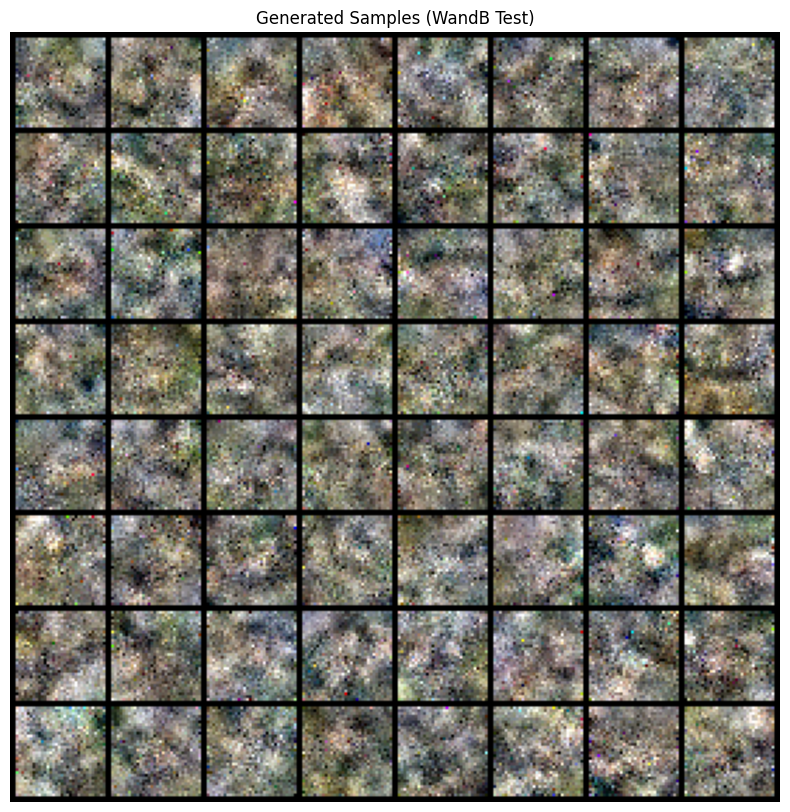

Logged final samples to WandB.


epoch,▁▂▃▃▄▅▆▆▇█
train/beta,▁▅████████
train/bpd,█▅▄▃▃▂▂▂▁▁
train/kl,█▅▄▂▁▁▂▂▃▃
train/loss,█▅▄▃▃▂▂▂▁▁
train/lr,██▇▇▆▄▃▂▂▁
train/recon,█▅▄▃▃▂▂▂▁▁
train/step_bpd,█▃▃▂▂▂▁▂▁▁
train/step_kl,▅█▆▂▂▁▁▂▂▂
train/step_loss,█▃▃▂▂▂▁▂▁▁
+3,...


In [32]:
# Load best model
from src.vae.model import NVAE
import torchvision.utils as vutils

model = NVAE(
    hidden_dim=config['hidden_dim'],
    latent_dim=config['latent_dim'],
    num_scales=config['num_scales']
).to(device)

model.load_state_dict(torch.load(os.path.join(config['model_save_dir'], 'nvae_best.pth')))
print("Loaded best model.")

# Generate
samples = generate_samples(model, num_samples=64, temperature=0.8, device=device)

# Visualize locally
plt.figure(figsize=(10, 10))
grid_img = vutils.make_grid(samples, nrow=8, normalize=True)
plt.imshow(grid_img.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.title("Generated Samples (WandB Test)")
plt.show()

# Log to WandB if active
if wandb.run is not None:
    wandb.log({
        "final_evaluation/generated_samples_grid": [wandb.Image(grid_img, caption="Final Generated Samples (T=0.8)")]
    })
    print("Logged final samples to WandB.")
    wandb.finish()